# Understanding the Raw Input Data

## Background

The dataset provided by the DHS for this competition comes in the form of binary files.  The files contain headers and the readings from the mm wave scanners organized in various spatial arrangements.  For this project, we have chosen the data set that has been created by projecting mm wave scanner readings into two dimensional images of subjects at 64 equally spaced angles.  In addition, the DHS has furnished labels indicating whether there is a threat present in each of 14 body zones of the scanned subject. 

## Data Size

The total size of the data is too large to load the dataset completely into memory (50.2GB).  Therefore, I chose to save the data into an AWS S3 bucket to facilitate access to the data without the need for downloading a local copy.  

## Data Access and Total Samples

Below, we will connect to the S3 bucket and verify our access by counting the number of samples in the data set.

In [4]:
import HelperFuncs as hfuncs

# Use helper file to connect to aws S3 bucket.
AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY = hfuncs.GetAWSCredentials()
client = hfuncs.GetAWSClient(AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY)
myBucket = client.Bucket(hfuncs.RAW_DATA_BUCKET)

# Count the number of samples 
contents = [k.key for k in myBucket.objects.all()]
contents = contents[1:] # Remove initial empty key in the result set.

print("Total number of samples: {}".format(len(contents)))

Total number of samples: 1247


## Data Format

The file headers describe technical specifications of the scan but don't supply any information that might be predictive of a threat being present. 

In [5]:
import IOFunctions as iof
import numpy as np
import pprint as pp
import os

# Choose a random sample key, download, and read its headers and data.
key = np.random.choice(contents,1)[0]

# Download into temp directory and retrieve headers and data.
img_id = key.strip().replace(hfuncs.RAW_DATA_DIRECTORY,'')
path = os.path.join(hfuncs.TEMP_DIR,img_id)

with open(path,"w+b") as f:
    myBucket.download_fileobj(key,f)
    try:
        sample_data = iof.read_data(path)
        sample_header = iof.read_header(path)
        print("Data successfully retrieved from file {}!".format(img_id))
    except:
        print("Something went wrong. Try again!")


Data successfully retrieved from file efcc0a2063eb1e9a101b57ad94345747.a3daps!


### Headers

In [6]:
pp.pprint(sample_header)

{'adc_max_voltage': array([ 1.10000002], dtype=float32),
 'adc_min_voltage': array([-1.10000002], dtype=float32),
 'adc_type': array([17], dtype=int16),
 'ahis_software_version': array([ 7.0999999], dtype=float32),
 'avg_data_value': array([ 9480.55566406], dtype=float32),
 'azimuth_offset_angle': array([ 0.], dtype=float32),
 'band_width': array([ 30058.70898438], dtype=float32),
 'comments1': b'                                                            '
              b'                    ',
 'comments2': b'                                                            '
              b'                    ',
 'config_type': array([2], dtype=int16),
 'data_scale_factor': array([  8.85990175e-06], dtype=float32),
 'data_storage_order': array([9], dtype=int16),
 'data_type': array([5], dtype=int16),
 'data_units': array([0], dtype=int16),
 'date_modified': b'',
 'date_processed': b'',
 'depth_recon': array([ 0.], dtype=float32),
 'edge_weighting': array([0], dtype=uint16),
 'elevation_o

## Data

The data is organized into 2D "images" of the signal response distributed accross 64 angles. 

Data has shape: (512, 660, 64)


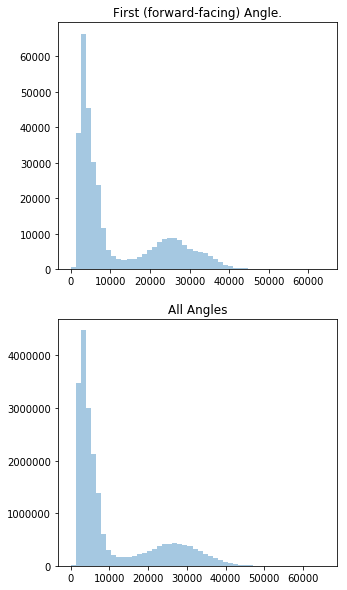

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns
% matplotlib inline

# Display data shape
shape = sample_data.shape
print("Data has shape: {}".format(shape))

# Visualize the distribution of values in the data array for 1 angle
# and all angles. 
fig, axes = plt.subplots(2,1,figsize=(5,10))

axes[0].set_title("First (forward-facing) Angle.")
sns.distplot(sample_data[:,:,0].flatten(),ax = axes[0],kde= False)

axes[1].set_title("All Angles")
sns.distplot(sample_data.flatten(),ax= axes[1],kde= False)


Visualize the data.

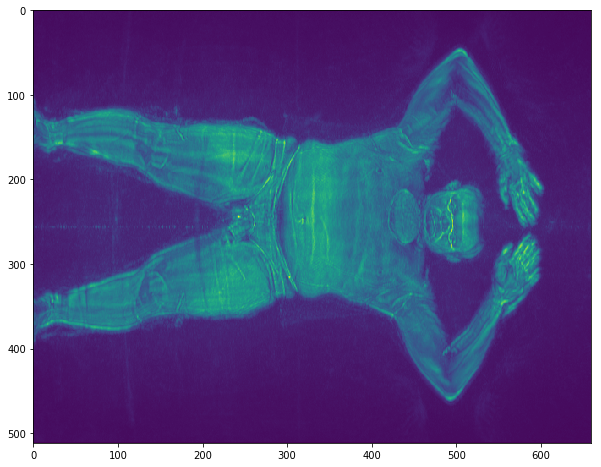

In [9]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
img = ax.imshow(sample_data[:,:,0],cmap='viridis')

The axes are inverted. Let's visualize the image upright by flipping the transpose. 

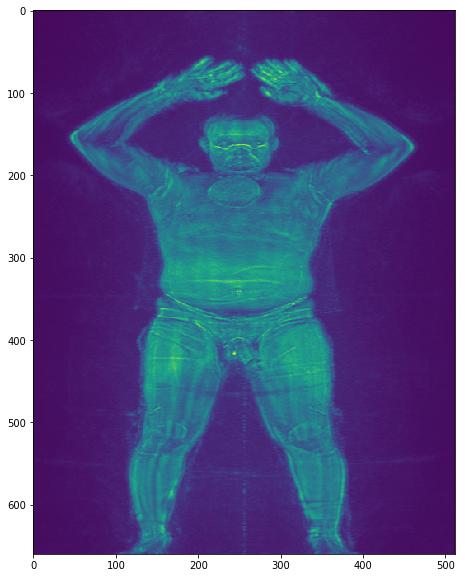

In [10]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
img = ax.imshow(np.flipud(sample_data[:,:,0].transpose()),cmap='viridis')

## Distribution for Subset of Data

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns
% matplotlib inline


# Choose a random sample key, download, and read its headers and data.
keys = np.random.choice(contents,10)
sample_data_subset = np.zeros((10,shape[0],shape[1],shape[2]))

i = 0
for key in keys:
    # Download into temp directory and retrieve headers and data.
    img_id = key.strip().replace(hfuncs.RAW_DATA_DIRECTORY,'')
    path = os.path.join(hfuncs.TEMP_DIR,img_id)

    with open(path,"w+b") as f:
        myBucket.download_fileobj(key,f)
        try:
            sample_data_subset[i] = iof.read_data(path)
            print("Data successfully retrieved from file {}!".format(img_id))
            i += 1
        except:
            print("Something went wrong. Try again!")
    


Data successfully retrieved from file 7828d838474e3b54306a164d1ba6419d.a3daps!
Data successfully retrieved from file c67e64fd5203e870a8b372e2817ab8bf.a3daps!
Data successfully retrieved from file acbd8470813a92fd5ff9c6d2c33ac614.a3daps!
Data successfully retrieved from file ee08cba6fcdc5738a4ebcc8f6d57de03.a3daps!
Data successfully retrieved from file 82bc59130f8a6f11022cd90a91acdf0a.a3daps!
Data successfully retrieved from file 1a17ad2b79f88b7423fdc0e3b91b0270.a3daps!
Data successfully retrieved from file b39b2fb7fb34ad998d8071b6c54e0dd5.a3daps!
Data successfully retrieved from file 5da7c347386a34d4bd185a92ffbf2a17.a3daps!
Data successfully retrieved from file e195068859c5847b028c905dd1ccb81d.a3daps!
Data successfully retrieved from file 06f07ef12a24cd5ab6aa457ac8afa2a0.a3daps!


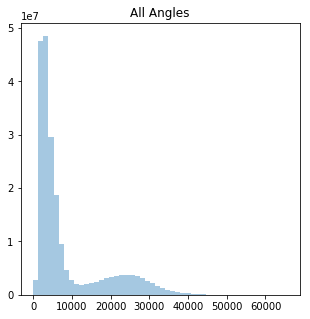

In [12]:
# Plot distribution for random subset of 10 images 
fig, axes = plt.subplots(1,1,figsize=(5,5))
axes.set_title("All Angles")
sns.distplot(sample_data_subset.flatten(),ax= axes,kde= False)

#### Observations

We can see from the images above that there is a substantial amount of noise.  The noise takes the form of random signal variation even at large disances from the subject.  Since the background takes up the majority of the image, we may want to preprocess these images to eliminate some of this background noise.

In the distribution of the signal, there is a large peak at around 5000.  A simple approach to clean these images would be to make the minimum signal 7000.  In this way, there would not be as much noisy variation around the areas of interest.

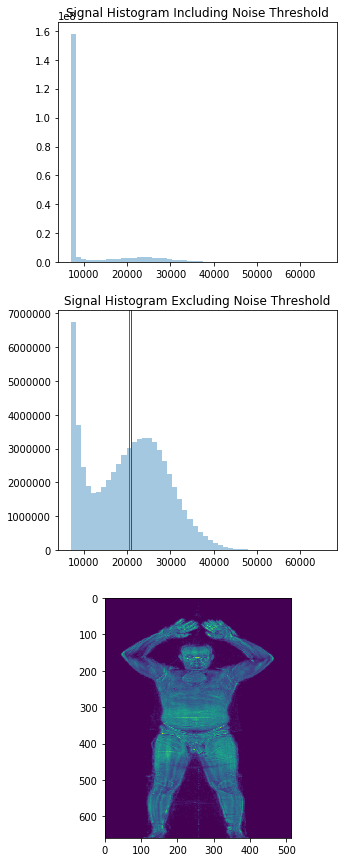

In [15]:
# Simple noise reduction
def ReduceNoise(x, thresh=7000):
    if x < thresh:
        x = thresh
    return x

ReduceNoise_v = np.vectorize(ReduceNoise)
sample_data_subset_nonoise = ReduceNoise_v(sample_data_subset).flatten()
sample_data_nonoise = ReduceNoise_v(sample_data)

# Set axes up
fig, axes = plt.subplots(3,1,figsize=(5,15))
axes[0].set_title("Signal Histogram Including Noise Threshold")
axes[1].set_title("Signal Histogram Excluding Noise Threshold")
axes[2].set_title("De-Noised Image")

# Distribution
sns.distplot(sample_data_subset_nonoise,kde= False,ax=axes[0])

mean = np.mean(sample_data_subset_nonoise[sample_data_subset_nonoise > 7000])
median = np.median(sample_data_subset_nonoise[sample_data_subset_nonoise > 7000])
sns.distplot(sample_data_subset_nonoise[sample_data_subset_nonoise > 7000],
             kde= False,ax=axes[1])
axes[1].axvline(mean,linewidth=1)
axes[1].axvline(median,linewidth=1,color='r')
axes[2].imshow(np.flipud(sample_data_nonoise[:,:,0].transpose()),cmap='viridis')


In [16]:
print("Excluding data at or below the treshold, the mean signal was {0:.0f} and the median was {1:.0f}".format(mean,median))

Excluding data at or below the treshold, the mean signal was 20384 and the median was 20934


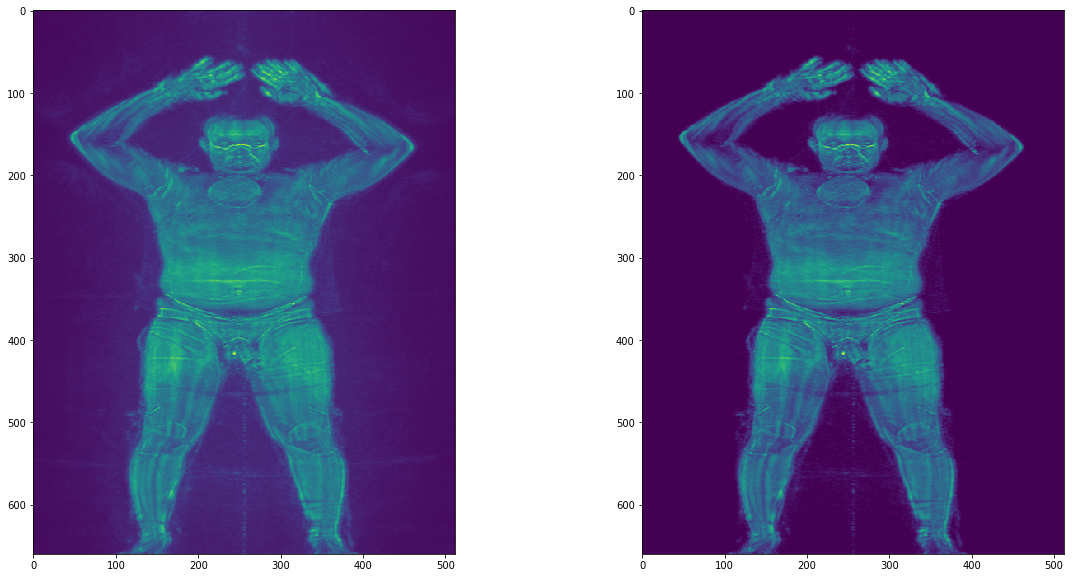

In [17]:
# Visualization
fig, axes = plt.subplots(1,2,figsize=(20,10))

axes[0].imshow(np.flipud(sample_data[:,:,0].transpose()),cmap='viridis')
axes[1].imshow(np.flipud(sample_data_nonoise[:,:,0].transpose()),cmap='viridis')

This simple technique makes the image crisper and eliminates uninformative background noise.

## Data Labels

The labels for this task are provided in long format.  That is, we have a row for each image_id-zone permutation indicating whether there is a threat present (1) or not (0).

In [18]:
import pandas as pd 

labels = pd.read_csv(hfuncs.LABELS_FILE)
labels.head(10)

,Id,Probability
0,00360f79fd6e02781457eda48f85da90_Zone1,0
1,00360f79fd6e02781457eda48f85da90_Zone10,0
2,00360f79fd6e02781457eda48f85da90_Zone11,0
3,00360f79fd6e02781457eda48f85da90_Zone12,0
4,00360f79fd6e02781457eda48f85da90_Zone13,0
5,00360f79fd6e02781457eda48f85da90_Zone14,1
6,00360f79fd6e02781457eda48f85da90_Zone15,0
7,00360f79fd6e02781457eda48f85da90_Zone16,0
8,00360f79fd6e02781457eda48f85da90_Zone17,0
9,00360f79fd6e02781457eda48f85da90_Zone2,0


The body zones correspond to the following regions of the body:

![BodyZones](body_zones.png)

#### Descriptive Statistics

Below, a zone feature is created from the target data and the positive rate for each zone is calculated.

In [19]:
import IOFunctions as iof

# Use helper function that takes list of [Id,Probability] and
# returns list of [img_ids,zone probabilities*]
labels_list = [[i,j] for i,j in zip(labels['Id'],labels['Probability'])]
labels_merged = iof.merge_17(labels_list)

# Unpack probabilities array
labels_merged_flat = []
for row in labels_merged:
    img_id = row[0] 
    zone_probs = row[1]
    labels_merged_flat.append([img_id,*zone_probs])

# Convert data to pandas df
labels_merged_df = pd.DataFrame(labels_merged_flat)
# Get data shape
print("Shape of data:{}".format(labels_merged_df.shape))
labels_merged_df.head(5)


Shape of data:(1147, 18)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,00360f79fd6e02781457eda48f85da90,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0043db5e8c819bffc15261b1f1ac5e42,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,0050492f92e22eed3474ae3a6fc907fa,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
3,006ec59fa59dd80a64c85347eef810c7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0097503ee9fa0606559c56458b281a08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [20]:
# Positive rate for each zone
df_melted = pd.melt(labels_merged_df,id_vars = (0),var_name = 'Zone',value_name = 'Probability')
df_summary = df_melted.groupby('Zone')['Probability'].agg(['sum','count'])
df_summary['Pct'] = df_summary['sum']/df_summary['count']*100
df_summary.sort_values('Pct',axis=0,ascending=False,inplace=True)
df_summary



,sum,count,Pct
Zone,,,
1,133,1147,11.595466
2,126,1147,10.985179
8,124,1147,10.810811
14,122,1147,10.636443
15,118,1147,10.287707
6,116,1147,10.113339
11,116,1147,10.113339
13,110,1147,9.590235
16,109,1147,9.503051


Text(0.5,1,'Distribution of Number of Threats per Sample')

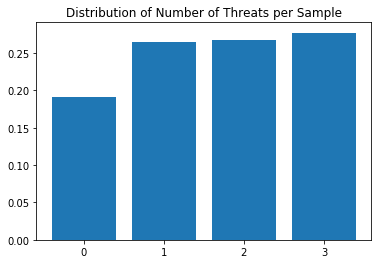

In [21]:
def addProb(x):
    return sum(x[1:18])
labels_merged_df['Sum'] = labels_merged_df.apply(addProb,axis=1)
df_SumDist = labels_merged_df.groupby('Sum')[0].count()/labels_merged_df[0].count()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.bar(df_SumDist.index,df_SumDist)
ax.set_xticks([0,1,2,3])
ax.set_title("Distribution of Number of Threats per Sample")

The positive rate for the various zones varies between ~ 8% to ~ 11.5%.  This means that there is certainly overlap between the zones and that we will have to keep in mind the imbalance when choosing, and implementing, a supervised learning technique. 

Further, there are 1147 samples in the labels but we know that there are 1247 samples in the full data set.  That means that there are 100 samples for which no labels were provided.  We will have to take care to address this issue when we create a clean data set. 

### Visulalizing the Threat

So what might a threat look like?  Let's create a visualization for a sample we know to contain a threat: item 5 in our labels data frame. 

In [22]:
# Item 5 from our labels dataframe
key = '{}00360f79fd6e02781457eda48f85da90.a3daps'.format(hfuncs.RAW_DATA_DIRECTORY)

# Download into temp directory and retrieve headers and data.
img_id = key.strip().replace(hfuncs.RAW_DATA_DIRECTORY,'')
path = os.path.join(hfuncs.TEMP_DIR,img_id)

with open(path,"w+b") as f:
    myBucket.download_fileobj(key,f)
    try:
        sample_data = iof.read_data(path)
        sample_header = iof.read_header(path)
        print("Data successfully retrieved from file {}!".format(img_id))
    except:
        print("Something went wrong. Try again!")

Data successfully retrieved from file 00360f79fd6e02781457eda48f85da90.a3daps!


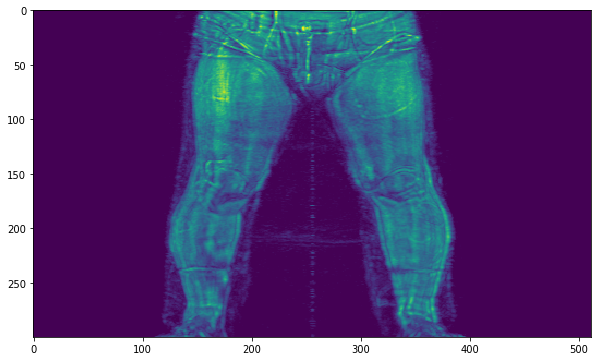

In [23]:
sample_data_nonoise = ReduceNoise_v(sample_data)

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
img = ax.imshow(np.flipud(sample_data_nonoise[:,:300,0].transpose()),cmap='viridis')

From the image above we may see a slight difference in the appearance of the knees.  The threat seems to be located just above the subject's right knee.  One can trace the faint outline of the lower portion of the foreign object, but it is not obvious from a perfunctory look that the outlines around the knee are any different from those that appear throughout the leg.  

This visulization helps us appreciate the difficulty of determining whether there is a threat from visual inspection, even by a human.
